## Data Cleaning

Using a test run dataset, I show how the json data is structured

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('data/test-run-5.json', 'r') as file:
    data = json.load(file)

In [3]:
data

[{'number_of_runs': 25, 'number_of_simulation_iterations': 1000},
 {'final_bankroll': 0,
  'rounds_played': 9,
  'initial_bankroll': 100,
  'round_outcomes': [5, -5, -20, -5, -5, -5, -5, -5, -10],
  'node_statistics': [[{'hand': ['J', 'K'],
     'action': 'stand',
     'action_history': ['stand'],
     'player_value': 20,
     'dealer_upcard': '10',
     'final_dealer_hand': ['10', '7'],
     'final_dealer_value': 17}],
   [{'hand': ['K', '4'],
     'action': 'stand',
     'action_history': ['stand'],
     'player_value': 14,
     'dealer_upcard': '8',
     'final_dealer_hand': ['8', '9'],
     'final_dealer_value': 17}],
   [{'hand': ['3', '3', '5'],
     'action': 'double',
     'action_history': ['double'],
     'player_value': 6,
     'dealer_upcard': '9',
     'final_dealer_hand': ['9', '4', '6'],
     'final_dealer_value': 19}],
   [{'hand': ['J', '3'],
     'action': 'stand',
     'action_history': ['stand'],
     'player_value': 13,
     'dealer_upcard': '6',
     'final_dealer

## Load main dataset

In [4]:
df = pd.read_json('data/main-run-1.json')
#df

In [5]:
metadata = df[['number_of_runs', 'number_of_simulation_iterations']].dropna()
metadata

,number_of_runs,number_of_simulation_iterations
0,25.0,1000.0


In [6]:
final_results = df[['final_bankroll', 'rounds_played', 'initial_bankroll']].dropna()
final_results

,final_bankroll,rounds_played,initial_bankroll
1,0.0,35.0,100.0
2,-10.0,32.0,100.0
3,0.0,31.0,100.0
4,10.0,50.0,100.0
5,5.0,50.0,100.0
6,20.0,50.0,100.0
7,115.0,50.0,100.0
8,0.0,47.0,100.0
9,35.0,50.0,100.0
10,0.0,42.0,100.0


In [7]:
game_data = df[['round_outcomes']].dropna().reset_index(names='game')

# Explode the 'round_outcomes' column to separate each outcome into its own row
game_data = game_data.explode('round_outcomes').reset_index(drop=True)

# Add round numbers for each game
game_data['round'] = game_data.groupby('game').cumcount() + 1

# Ensure 'round_outcomes' is numeric
game_data['round_outcomes'] = pd.to_numeric(game_data['round_outcomes'], errors='coerce')

# Calculate the bankroll with cumsum resetting for each game
game_data['bankroll'] = 100 + game_data.groupby('game')['round_outcomes'].cumsum()

game_data



,game,round_outcomes,round,bankroll
0,1,-5,1,95
1,1,-5,2,90
2,1,-5,3,85
3,1,-10,4,75
4,1,-10,5,65
...,...,...,...,...
1073,25,5,41,10
1074,25,-5,42,5
1075,25,5,43,10
1076,25,-5,44,5


In [8]:
node_statistics = []
for game_index, game_nodes in enumerate(df['node_statistics'].dropna()):
    for round_index, round_nodes in enumerate(game_nodes):
        for node in round_nodes:
            #our stats data collects the final agents hand for each round so we want to retrieve state value by using the num of actions in action history
            if 'split_right'in node['action_history'] or 'split_left' in node['action_history']: #splits record 2 actions within the same hand in our game engine logic but we want to treat each action for every hand as an individual state
                node_statistics.append({
                    'game': game_index + 1,
                    'round': round_index + 1,
                    'state': len(node['action_history']) - 1,
                    'hand': node['hand'][:len(node['action_history'])],
                    'action': node['action'],
                    'action_history': node['action_history'],
                    'player_value': node['player_value'],
                    'dealer_upcard': node['dealer_upcard'],
                    'final_dealer_hand': node['final_dealer_hand'],
                    'final_dealer_value': node['final_dealer_value']
                })
            else:
                node_statistics.append({
                    'game': game_index + 1,
                    'round': round_index + 1,
                    'state': len(node['action_history']),
                    'hand': node['hand'][:len(node['action_history']) + 1],
                    'action': node['action'],
                    'action_history': node['action_history'],
                    'player_value': node['player_value'],
                    'dealer_upcard': node['dealer_upcard'],
                    'final_dealer_hand': node['final_dealer_hand'],
                    'final_dealer_value': node['final_dealer_value']
                })

node_statistics_df = pd.DataFrame(node_statistics)

node_statistics_df

,game,round,state,hand,action,action_history,player_value,dealer_upcard,final_dealer_hand,final_dealer_value
0,1,1,1,"[10, 3]",hit,[hit],13,8,"[8, 2, 5, K]",25
1,1,1,2,"[10, 3, 4]",hit,"[hit, hit]",17,8,"[8, 2, 5, K]",25
2,1,1,3,"[10, 3, 4, A]",hit,"[hit, hit, hit]",18,8,"[8, 2, 5, K]",25
3,1,2,1,"[2, 5]",hit,[hit],7,8,"[8, 10]",18
4,1,2,2,"[2, 5, 6]",hit,"[hit, hit]",13,8,"[8, 10]",18
...,...,...,...,...,...,...,...,...,...,...
1448,25,40,1,"[J, 4]",stand,[stand],14,3,"[3, K, 4]",17
1449,25,41,1,"[Q, 8]",stand,[stand],18,8,"[8, 5, 3, A]",17
1450,25,42,1,"[K, 9]",hit,[hit],19,9,"[9, A]",20
1451,25,44,1,"[5, 7]",hit,[hit],12,K,"[K, 6, 4]",20


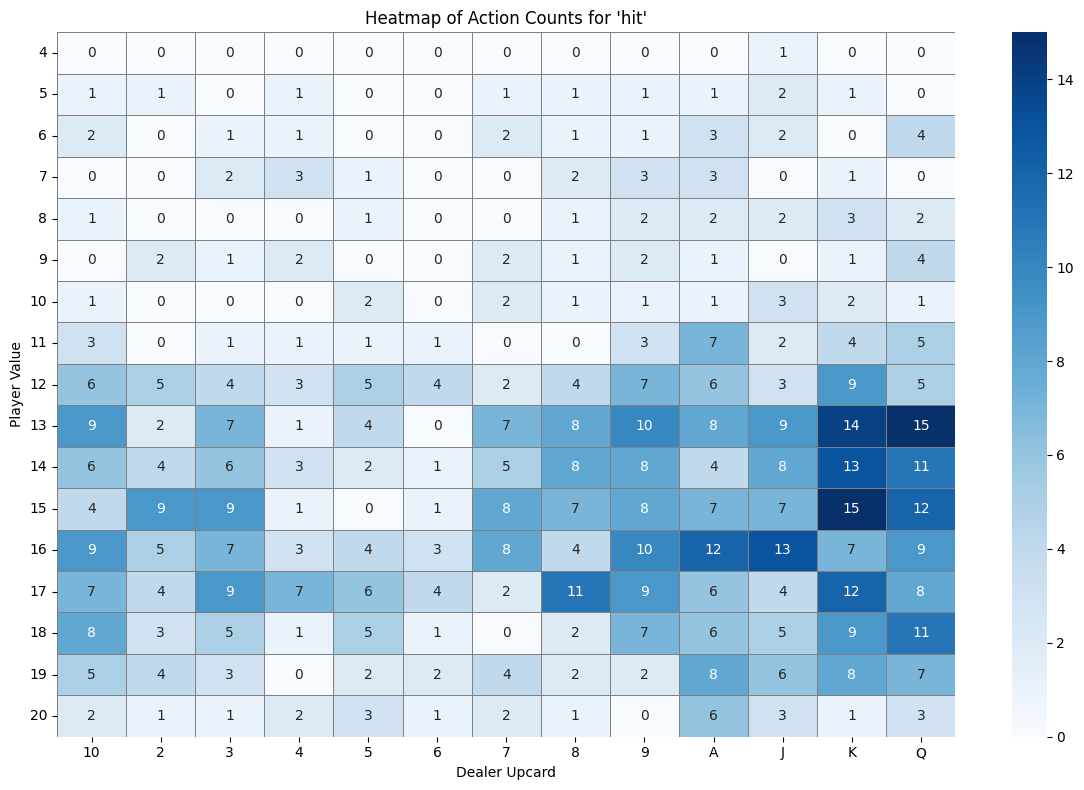

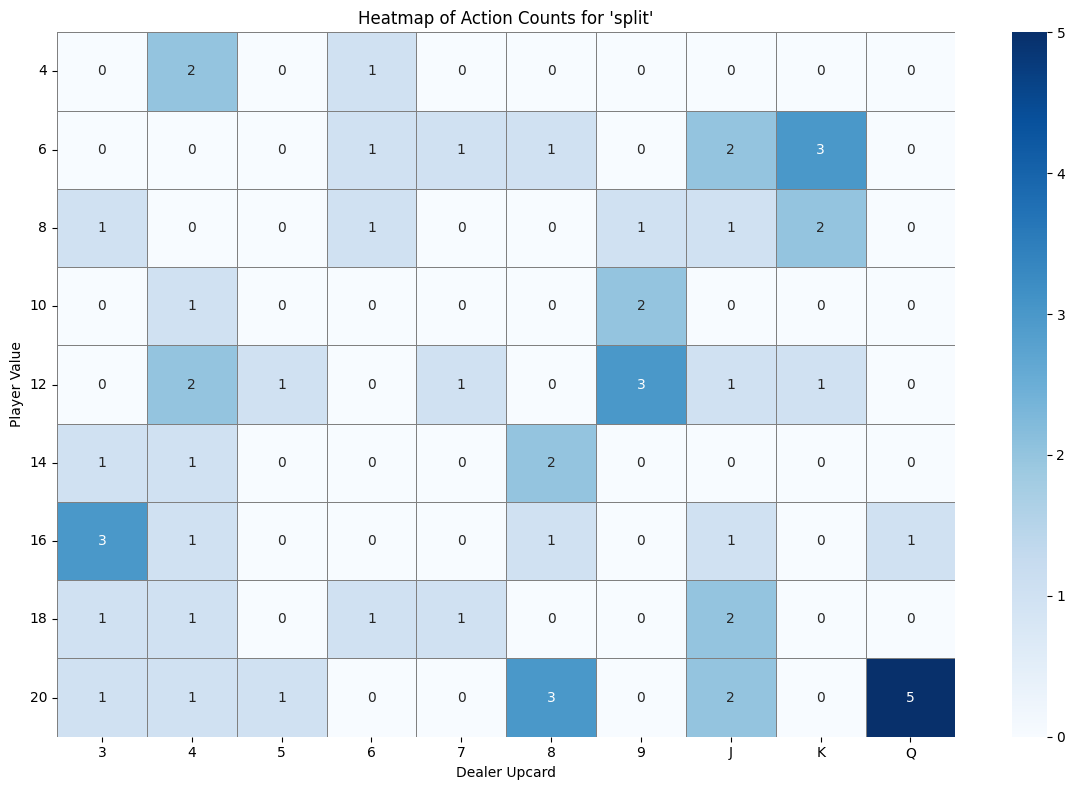

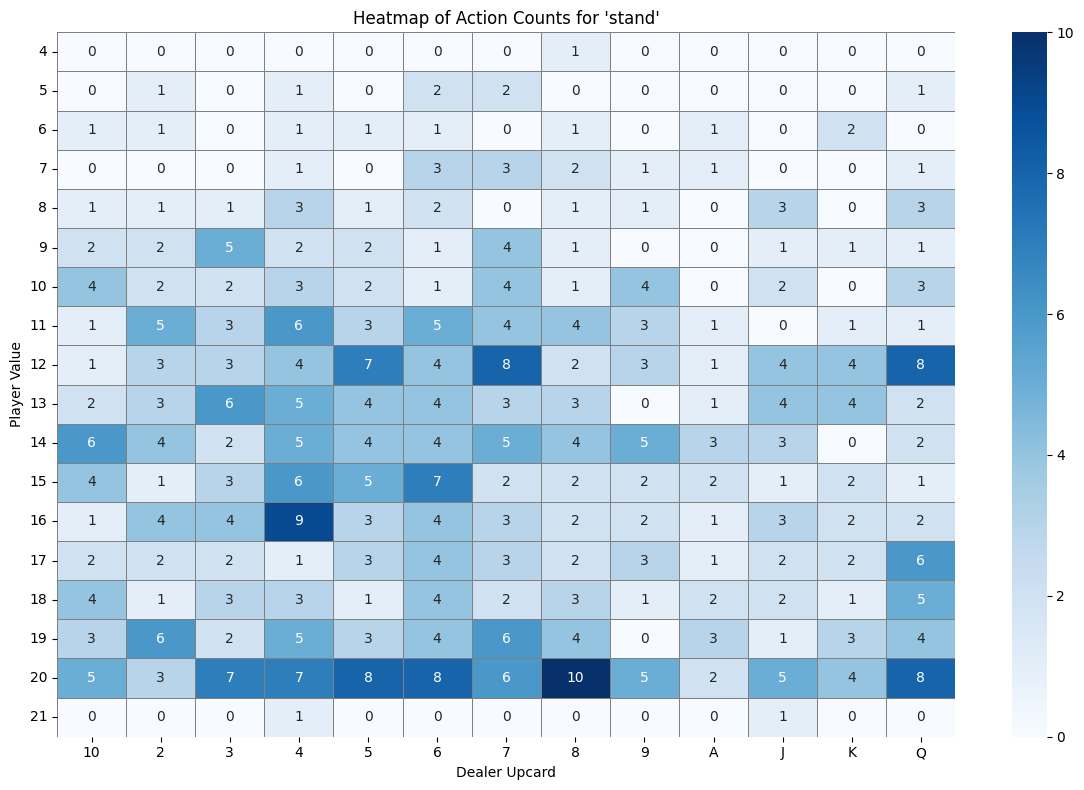

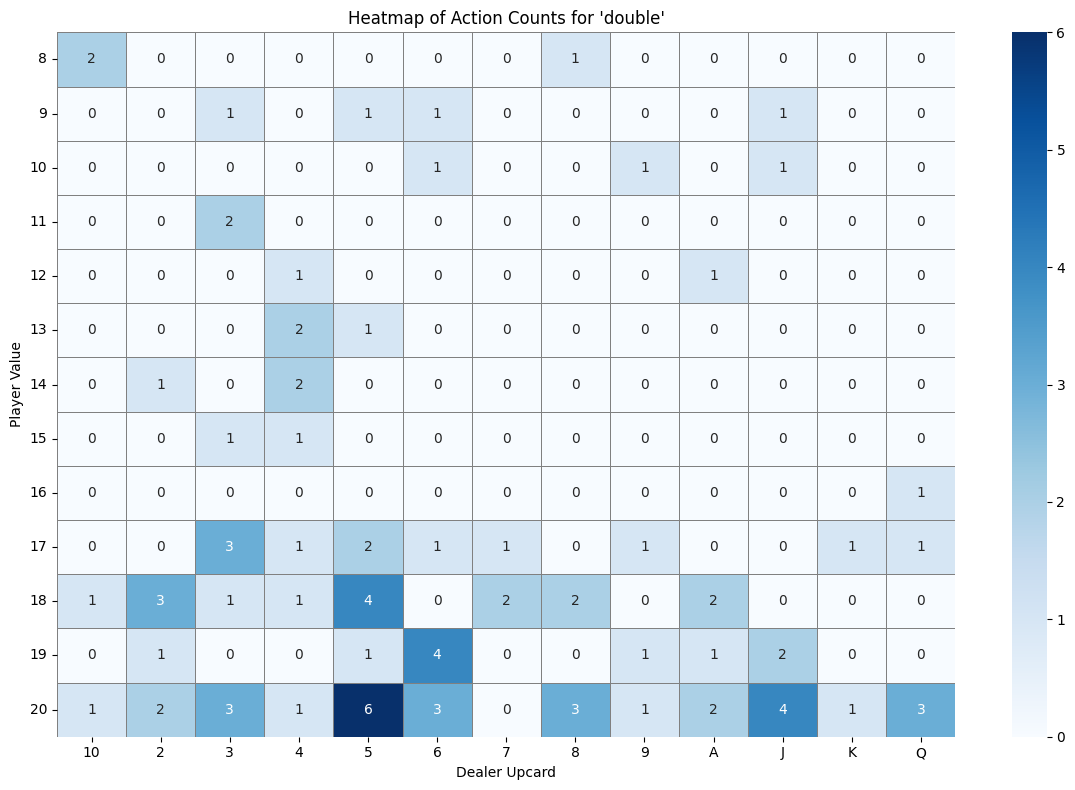

In [9]:
# Loop through each unique action in the 'action' column
for action in node_statistics_df['action'].unique():
    # Filter the dataframe for the current action
    action_data = node_statistics_df[node_statistics_df['action'] == action]
    
    # Create a pivot table to count occurrences of player_value and dealer_upcard
    heatmap_data = action_data.pivot_table(index='player_value', columns='dealer_upcard', values='action', aggfunc='count', fill_value=0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=True,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(f"Heatmap of Action Counts for '{action}'")
    plt.xlabel("Dealer Upcard")
    plt.ylabel("Player Value")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Exploratory Analysis

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

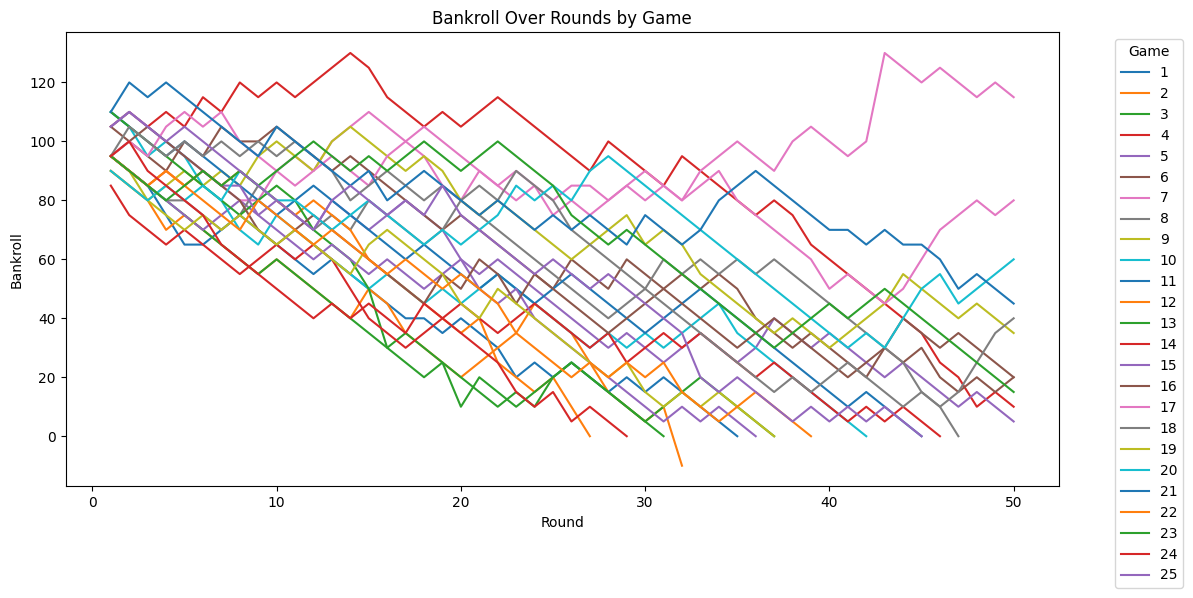

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=game_data, x='round', y='bankroll', hue='game', palette='tab10')
plt.title('Bankroll Over Rounds by Game')
plt.xlabel('Round')
plt.ylabel('Bankroll')
plt.legend(title='Game', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

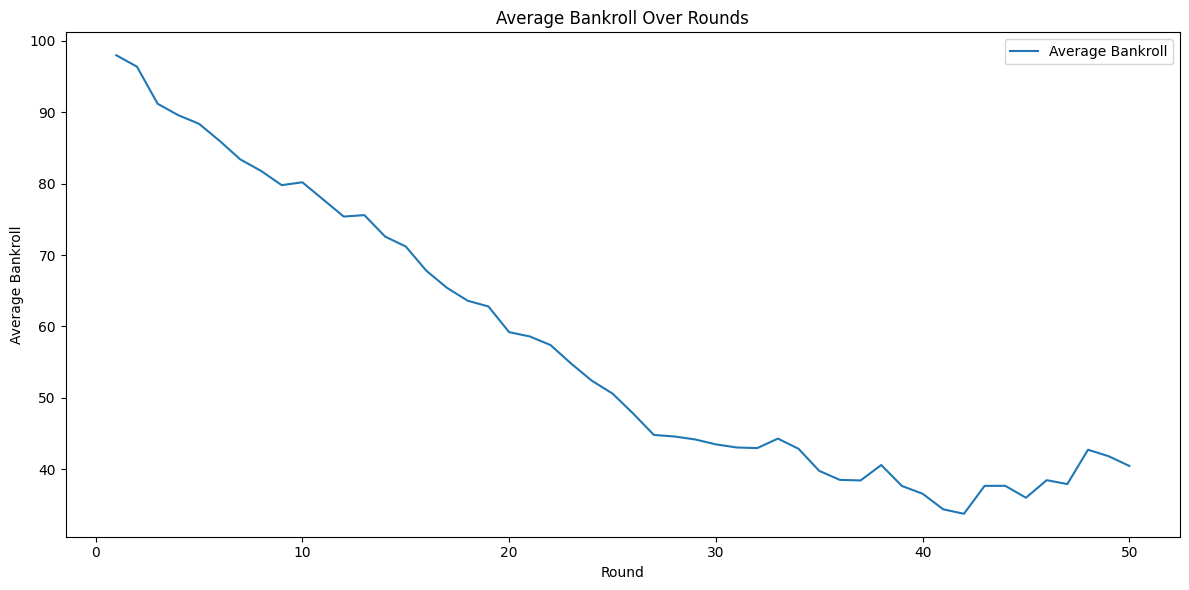

In [12]:
average_bankroll = game_data.fillna(0).groupby('round')['bankroll'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_bankroll, label='Average Bankroll')
plt.title('Average Bankroll Over Rounds')
plt.xlabel('Round')
plt.ylabel('Average Bankroll')
plt.legend()
plt.tight_layout()
plt.show()

### Decision Tree example

A small example of what the MCTS tree looks like

In [16]:
with open("misc/mcts_tree.json", "r") as f:
    data = json.load(f)

# Flatten into a DataFrame
rows = []
for node in data:
    rows.append({
        "id": node["id"],
        "parent_id": node["parent_id"],
        "action": node["action_history"][-1] if node["action_history"] else "ROOT",
        "hand": "-".join(node["agent_hand"][0]),
        "value": node["value"],
        "visits": node["visits"],
        "best_action": node["best_action"]
    })

dataset = pd.DataFrame(rows)
dataset.to_csv("misc/mcts_tree_flat.csv", index=False)

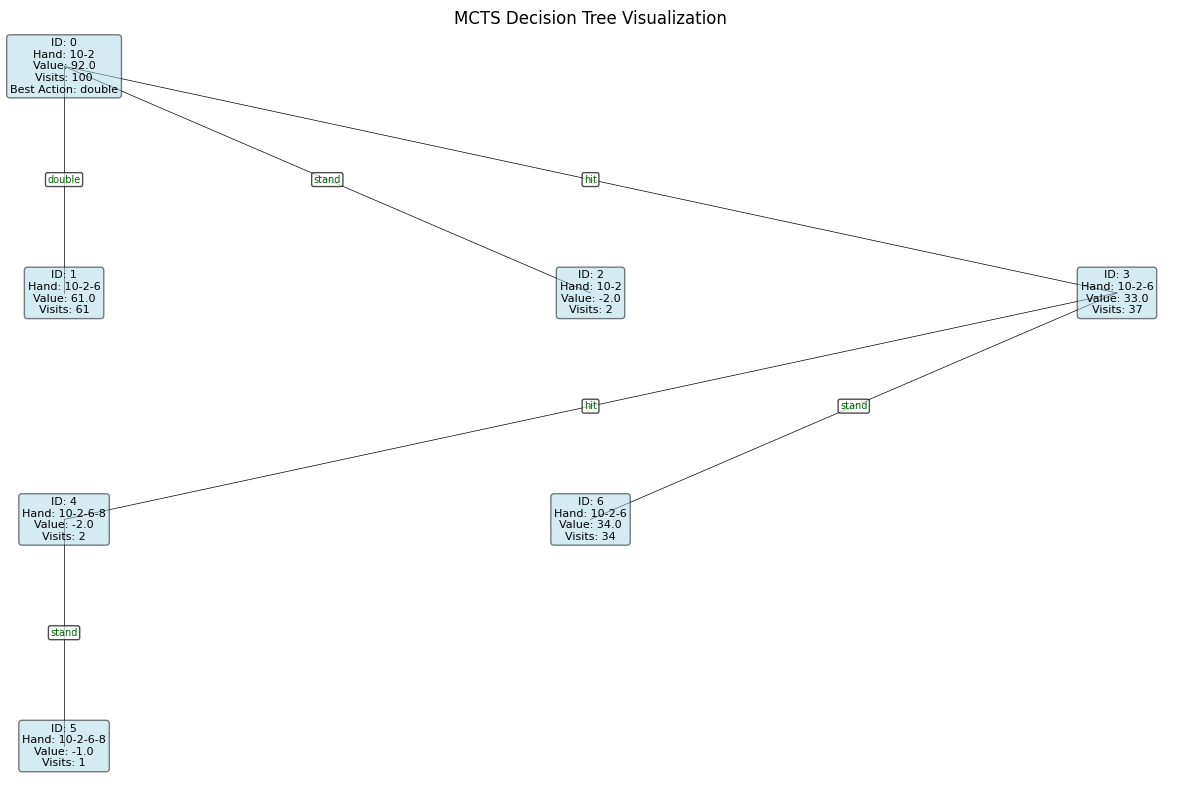

In [17]:
dataset['parent_id'] = dataset['parent_id'].fillna(-1).astype(int)
dataset['id'] = dataset['id'].astype(int)

node_info = dataset.set_index('id').T.to_dict()
# Define parent and child nodes
children = {}
root_id = None
for _, row in dataset.iterrows():
    node_id = row['id']
    parent_id = row['parent_id']
    if parent_id == -1:
        root_id = node_id
    else:
        children.setdefault(parent_id, []).append(node_id)

pos = {}
levels = {}
queue = [(root_id, 0)]
visited = set()

while queue:
    current_node, level = queue.pop(0)
    if current_node in visited:
        continue
    visited.add(current_node)
    levels[current_node] = level
    for child in children.get(current_node, []):
        queue.append((child, level + 1))

# Count how many nodes are at each level
level_widths = {}
for node_id, level in levels.items():
    level_widths[level] = level_widths.get(level, 0) + 1

level_x_positions = {level: 0 for level in sorted(level_widths)}

sorted_nodes = sorted(levels.items(), key=lambda x: (x[1], x[0]))
y_spacing = -1
x_spacing = 1.5
# set x, y position for each node
for node_id, level in sorted_nodes:
    x = level_x_positions[level] * x_spacing
    y = level * y_spacing
    pos[node_id] = (x, y)
    level_x_positions[level] += 1

center_offset = (max(level_widths.values()) - 1) * x_spacing / 2
for node_id in pos:
    x, y = pos[node_id]
    pos[node_id] = (x - center_offset, y)

fig, ax = plt.subplots(figsize=(12, 8))

# Draw edges 
for parent_id, child_list in children.items():
    if parent_id in pos:
        parent_pos = pos[parent_id]
        for child_id in child_list:
            if child_id in pos:
                child_pos = pos[child_id]
                ax.plot([parent_pos[0], child_pos[0]], [parent_pos[1], child_pos[1]], 'k-', linewidth=0.5)

# Create node labels (ID, value, visits, etc.)
for node_id, position in pos.items():
    info = node_info.get(node_id, {})
    label = f"ID: {node_id}\nHand: {info.get('hand', 'N/A')}\nValue: {info.get('value', 'N/A')}\nVisits: {info.get('visits', 'N/A')}"
    if pd.notna(info.get('best_action')):
        label += f"\nBest Action: {info.get('best_action', 'N/A')}"
    ax.text(position[0], position[1], label, fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.5))

# Add action labels on edges
for parent_id, child_list in children.items():
    if parent_id in pos:
        parent_pos = pos[parent_id]
        for child_id in child_list:
            if child_id in pos:
                child_pos = pos[child_id]
                mid_x = (parent_pos[0] + child_pos[0]) / 2
                mid_y = (parent_pos[1] + child_pos[1]) / 2
                action = dataset[(dataset['id'] == child_id) & (dataset['parent_id'] == parent_id)].iloc[0]['action']
                ax.text(mid_x, mid_y, action, fontsize=7, ha='center', va='center', color='darkgreen',
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

ax.set_title('MCTS Decision Tree Visualization')
ax.axis('off')
ax.autoscale_view()
plt.tight_layout()
plt.show()

In this snippet, the dealer was holding an upcard of a King with a 5 downcard. Only 100 iterations are simulated for brevity so it's unlikely double down would always win in this scenario had we allowed for more possible states to be simulated. See log details